<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/97_65(%EC%A0%84%EC%B2%98%EB%A6%AC%2BGlove%2BGRU%2BCNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전작업

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, GRU, Bidirectional, GlobalMaxPooling1D,GlobalAveragePooling1D, Dropout,SpatialDropout1D,Conv1D,concatenate,Flatten
#Bidirectional은 양방향으로 데이터를 보기 위해서 사용되는 함수
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
#데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
train_data.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
X_train_raw = train_data['comment_text'].map(lambda com : clean_text(com))
X_test_raw = test_data['comment_text'].map(lambda com : clean_text(com))

bad_comment_cat = ['toxic', 'severe_toxic', 'obscene', 'threat',\
       'insult', 'identity_hate']
Y_train = train_data[bad_comment_cat]

In [ ]:
print("X train shape : ", X_train_raw.shape)
print("X test shape : ", X_test_raw.shape)
print("y train shape : ", Y_train.shape)

X train shape :  (159571,)
X test shape :  (153164,)
y train shape :  (159571, 6)


# 토큰화 작업하기

In [ ]:
max_features=20000
maxlen=200
embed_size=300


tok=Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(X_train_raw)
tok.fit_on_texts(X_test_raw)
X_train = sequence.pad_sequences(tok.texts_to_sequences(X_train_raw),
                        maxlen = maxlen, truncating = "pre")
X_test = sequence.pad_sequences(tok.texts_to_sequences(X_test_raw),
                       maxlen = maxlen, truncating = "pre")

In [ ]:
word_index = tok.word_index

In [ ]:
word_index = {e:i for e,i in word_index.items() if i <= max_features}

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,train_size=0.9, random_state=199)
print(x_train.shape," ",y_train.shape," ",x_val.shape," ",y_val.shape)

(143613, 200)   (143613, 6)   (15958, 200)   (15958, 6)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-04-06 05:32:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-06 05:32:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-06 05:32:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embedding_dict = dict()
f = open('glove.6B.300d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 300개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
embedding_matrix = np.zeros((max_features, 300))

In [ ]:
for word, i in word_index.items():
  tmp = embedding_dict.get(word)
  if tmp is not None:
    embedding_matrix[i-1] = tmp

# 모델 구성하기

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input)
layer = SpatialDropout1D(0.1)(layer)
layer = Bidirectional(GRU(128, return_sequences=True))(layer)
layer = Bidirectional(GRU(128, return_sequences=True))(layer)
layer = Conv1D(128, kernel_size = 3)(layer)   
layer = Conv1D(64, kernel_size = 3)(layer)  
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
layer = concatenate([avg_pool, max_pool])
layer = Dense(50,activation='relu')(layer)
layer = Flatten()(layer)
layer= Dense(6, activation="sigmoid")(layer)
model = Model(inputs = input, outputs = layer)  
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 256)     330240      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
hist = model.fit(x_train, y_train, epochs=100,batch_size=256, validation_data=(x_val,y_val), callbacks= [checkpoint,early_stop])

Epoch 1/100
561/561 [==============================] - 149s 199ms/step - loss: 0.1110 - accuracy: 0.8606 - val_loss: 0.0472 - val_accuracy: 0.9896

Epoch 00001: val_loss improved from inf to 0.04718, saving model to 01-0.04718.h5
Epoch 2/100
561/561 [==============================] - 111s 198ms/step - loss: 0.0450 - accuracy: 0.9796 - val_loss: 0.0446 - val_accuracy: 0.9939

Epoch 00002: val_loss improved from 0.04718 to 0.04458, saving model to 02-0.04458.h5
Epoch 3/100
561/561 [==============================] - 111s 198ms/step - loss: 0.0387 - accuracy: 0.9723 - val_loss: 0.0451 - val_accuracy: 0.9893

Epoch 00003: val_loss did not improve from 0.04458


In [ ]:
model.save('/content/drive/MyDrive/toxic1_model0404.h5')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('/content/drive/MyDrive/submission14.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

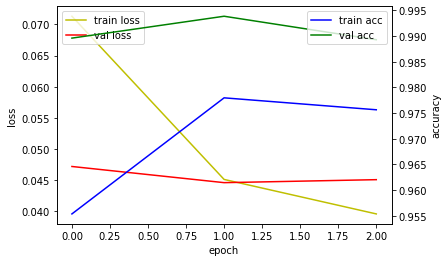

In [ ]:
acc_loss_plot(hist)